# **CFRM 523 Strategy Project**


# Summary


In their paper titled "Can We Learn to Beat the Best Stock" by Allan Borodin, Ran El-Yaniv, and Vincent Gogan published in Advances in Neural Information Processing Systems, volume 16, assert that traditional portfolio selection algorithms have limitations in consistently outperforming the market, and propose a novel algorithm called 'ANTICOR' to outperform the market and the best stock (achieving the total return that beats the market return and the best stock) by exploiting statistical relations between stocks. However, this algorithm, which is motivated by the philosophy of 'mean reversion', will fail to outperform the market return or even lose money if the stock growth rates are not stable in the long term or the period is not long enough to let the stock growth rates reverse back to the mean. Therefore, based on the Anticor algorithm, which adjusts portfolio weights based on past performance correlations, I extend the model by incorporating risk management, dynamic window size adjustment, and momentum indicators like RSI to achieve better returns and manage volatility more effectively. By implementing the enhanced Anticor algorithm and backtest it on historical (recent) stock price data, the results are more stable than the origin Anticor algorithm.

# **Hypothesis**

1. The improved Anticor algorithm can outperform the market return and the original Anticor algorithm

2. The improved Anticor algorithm manages volatility effectively and can achieve positive return

# **Introduction to the Portofolio Selection Problem**

Suppose a market consists of $m$ stocks.

Let $\mathbf{p}_t = \begin{pmatrix} p_t(1) \\ \vdots \\ p_t(m) \end{pmatrix}$ be the daily adjusted closing prices of the $m$ stocks for the $t^{th}$ day, where $p_t(j)$ is the price of the $j$th stock.

The market vector of relative prices $\mathbf{x}_t$ are given by $\mathbf{x}_t = \begin{pmatrix} x_t(1) \\ \vdots \\ x_t(m) \end{pmatrix}$, where $x_t(j) = \frac{p_t(j)}{p_{t-1}(j)}$.

A portfolio $\mathbf{b}$ is an allocation of wealth in the stocks, specified by the proportions $\mathbf{b} = \begin{pmatrix} b(1) \\ \vdots \\ b(m) \end{pmatrix}$ of current dollar wealth invested in each of the stocks, where $b(j) \geq 0$ and $\sum_{j} b(j) = 1$.

Therefore, the daily return of a portfolio $\mathbf{b}$ with respect to a market vector $\mathbf{x}$ is $\mathbf{b} \cdot \mathbf{x} = \sum_{j} b(j)x(j)$. And the (compound) total return $ret_X(\mathbf{b}_1, ..., \mathbf{b}_n)$, of a sequence of portfolios $\mathbf{b}_1, ..., \mathbf{b}_n$ with respect to a market sequence $X=\mathbf{x}_1, ..., \mathbf{x}_n$ is given by $\prod_{t=1}^{n} \mathbf{b}_t \cdot \mathbf{x}_t$.



# **Constraints, Benchmarks, and Objectives of Strategy**

**Objective of Strategy:** Maximize $\prod_{t=1}^{n} \mathbf{b}_t \cdot \mathbf{x}_t$ with respect to $\mathbf{b}_t$.

**Constraints:** $\mathbf{b}_t$ needs to add up to 100% for every $t$

some constraints appears in the improved Anticor algorithm for risk management:
1. threshold for weight transfers (transfer will not be implemented if weight transfer is less than threshold (arbitrary number we pick) considering the transaction fee raised in real situation)

2. minimum and maximum window sizes for dynamic window adjustment, and Volatility threshold for adjusting window size

**Benchmarks:** I use 2 benchmarks for evaluation. The first benchmark is the market return which is the uniform buy-and-hold strategy since generally it can represent the market. The second benchmark is the original Anticor algorithm as we want to find out how the improved algorithm performs compared to the original one.

# **Data Collection and Preparation**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**1. DJIA dataset (old)** \

The first dataset is the the thirty stocks composing the Dow Jones Industrial Average (DJIA) (originally for the two year period from Jan 14th, 2001 to Jan 14th, 2003) but with a new (recent) period from Jan 1st, 2025 to May 30th, 2024 (since I want to see how the Anticor algorithm and the improved algorithm perform with the same tickers as the paper but different period)


During the two year period from Jan 14th, 2001 to Jan 14th, 2003, the 30 stocks composing the DJIA:

From the Wall Street Journal: https://www.wsj.com/public/resources/documents/DowMemberHistory.pdf

Note some corporations renamed after restructuring or merging with other company. For example, Philip Morris Companies Inc. (PM) was restructured and spun off various entities. The current entity is Altria Group, Inc. (MO). United Technologies Corporation (UTX) merged with Raytheon Company to form Raytheon Technologies Corporation, which trades under the ticker symbol RTX.

Also note that the historical data for 'GM', 'SBC', 'KODK' are missing. General Motors Corporation (GM) filed for bankruptcy in 2009 and emerged as General Motors Company. SBC Communications Incorporated merged with AT&T Corporation, and the resulting entity rebranded as AT&T Inc. So we end up with 27 stocks in DJIA.

In [ ]:
stocks = ['MMM', 'AA', 'AXP', 'T', 'BA', 'CAT', 'C', 'KO', 'DD', 'XOM', 'GE', 'HPQ', 'HD', 'HON', 'INTC', 'IBM', 'IP', 'JPM', 'JNJ', 'MCD', 'MRK', 'MSFT', 'MO', 'PG', 'RTX', 'WMT', 'DIS']
start_date = '2024-01-01'
end_date = '2024-05-30'

DJIA_old_Data_Raw = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

DJIA_old_relative_price_withNA = DJIA_old_Data_Raw/DJIA_old_Data_Raw.shift(1) # here calculate the relative prices but note the first row is NA

DJIA_old_relative_price = DJIA_old_relative_price_withNA.iloc[1:] # drop the first row of NAs

DJIA_old_relative_price_log = np.log(DJIA_old_relative_price) # calculate the logarithms of relative prices

[*********************100%%**********************]  27 of 27 completed


**2. DJIA dataset**

Then the second dataset is the thirty stocks composing the Dow Jones Industrial Average (DJIA) for the period from Jan 1st, 2025 to May 30th, 2024. The period is the same as the first dataset, and the tickers also have strong overlap as the first dataset. So we may find out how the algorithms perform when the market is similar but with some difference in market composition.

In [ ]:
stocks = [
    "MMM",  # 3M Company
    "DOW",  # Dow Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com, Inc.
    "GS",  # The Goldman Sachs Group, Inc.
    "NKE",  # Nike, Inc.
    "AXP",  # American Express Company
    "HD",  # The Home Depot, Inc.
    "PG",  # The Procter & Gamble Company
    "AMGN",  # Amgen Inc.
    "HON",  # Honeywell International Inc.
    "CRM",  # Salesforce, Inc.
    "AAPL",  # Apple Inc.
    "INTC",  # Intel Corporation
    "TRV",  # The Travelers Companies, Inc.
    "BA",  # The Boeing Company
    "IBM",  # International Business Machines Corporation
    "UNH",  # UnitedHealth Group Incorporated
    "CAT",  # Caterpillar Inc.
    "JNJ",  # Johnson & Johnson
    "VZ",  # Verizon Communications Inc.
    "CVX",  # Chevron Corporation
    "JPM",  # JPMorgan Chase & Co.
    "V",  # Visa Inc.
    "CSCO",  # Cisco Systems, Inc.
    "MCD",  # McDonald's Corporation
    "WMT",  # Walmart Inc.
    "KO",  # The Coca-Cola Company
    "MRK",  # Merck & Co., Inc.
    "DIS"  # The Walt Disney Company
]
start_date = '2024-01-01'
end_date = '2024-05-30'

DJIA_Data_Raw = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

DJIA_relative_price_withNA = DJIA_Data_Raw/DJIA_Data_Raw.shift(1) # here calculate the relative prices but note the first row is NA

DJIA_relative_price = DJIA_relative_price_withNA.iloc[1:] # drop the first row of NAs

DJIA_relative_price_log = np.log(DJIA_relative_price) # calculate the logarithms of relative prices

[*********************100%%**********************]  30 of 30 completed


**3. S&P500 dataset**

According to data from Bloomberg, here I use the 25 stocks from S&P500 that had the largest weight (as of May. 2024) during the period from Jan 1st, 2024 to May 30th, 2024:

1. Microsoft Corporation (MSFT)
2. Apple Inc. (AAPL)
3. Nvidia Corporation (NVDA)
4. Amazon.com Inc. (AMZN)
5. Meta Platforms, Inc. Class A (formerly known as Facebook) (META)
6. Alphabet Inc. Class A (GOOGL)
7. Alphabet Inc. Class C (GOOG)
8. Berkshire Hathaway Inc. Class B (BRK.B)
9. Eli Lilly & Co. (LLY)
10. Broadcom Inc. (AVGO)
11. JPMorgan Chase & Co. (JPM)
12. Exxon Mobil Corporation (XOM)
13. UnitedHealth Group Incorporated (UNH)
14. Visa Inc. (V)
15. Tesla, Inc. (TSLA)
16. Mastercard Incorporated (MA)
17. Procter & Gamble Company (PG)
18. Johnson & Johnson (JNJ)
19. Home Depot, Inc. (HD)
20. Merck & Co., Inc. (MRK)
21. Costco Wholesale Corporation (COST)
22. AbbVie Inc. (ABBV)
23. Chevron Corporation (CVX)
24. Netflix Inc. (NFLX)
25. Salesforce.com, Inc. (CRM)



In [ ]:
stocks = ["MSFT", "AAPL", "NVDA", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "LLY", "AVGO", "JPM", "XOM", "UNH", "V", "TSLA", "MA", "PG", "JNJ", "HD", "MRK", "COST", "ABBV", "CVX", "NFLX", "CRM"]
start_date = '2024-01-01'
end_date = '2024-05-30'

SP500_Data_Raw = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

SP500_relative_price_withNA = SP500_Data_Raw/SP500_Data_Raw.shift(1)

SP500_relative_price = SP500_relative_price_withNA.iloc[1:] # drop the first row of NAs

SP500_relative_price_log = np.log(SP500_relative_price)

[*********************100%%**********************]  25 of 25 completed


**4. Nasdaq dataset**

The fourth dataset I use is the 25 stocks from Nasdaq that had the largest weight (as of May. 2024) during the period from Jan 1st, 2024 to May 30th, 2024:

1.	Microsoft Corp (MSFT)
2.	Apple Inc	(AAPL)
3.	NVIDIA Corp	(NVDA)
4.	Amazon.com Inc (AMZN)
5.	Broadcom Inc	(AVGO)
6.	Meta Platforms Inc	(META)
7.	Alphabet Inc	(GOOGL)
8.	Alphabet Inc	(GOOG)
9.	Costco Wholesale Corp	(COST)
10.	Tesla Inc	(TSLA)
11.	Netflix Inc	(NFLX)
12.	Advanced Micro Devices Inc	(AMD)
13.	PepsiCo Inc	(PEP)
14.	QUALCOMM Inc	(QCOM)
15.	Adobe Inc	(ADBE)
16.	Linde PLC	(LIN)
17.	T-Mobile US Inc	(TMUS)
18.	Cisco Systems Inc	(CSCO)
19.	Applied Materials Inc	(AMAT)
20.	Texas Instruments Inc	(TXN)
21.	Intuit Inc	(INTU)
22.	Amgen Inc	(AMGN)
23.	Comcast Corp	(CMCSA)
24.	Micron Technology Inc	(MU)
25.	Intuitive Surgical Inc	(ISRG)

In [ ]:
stocks = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'AVGO', 'META', 'GOOGL', 'GOOG', 'COST', 'TSLA', 'NFLX', 'AMD', 'PEP', 'QCOM', 'ADBE', 'LIN', 'TMUS', 'CSCO', 'AMAT', 'TXN', 'INTU', 'AMGN', 'CMCSA', 'MU', 'ISRG']
start_date = '2024-01-01'
end_date = '2024-05-30'

Nasdaq_Data_Raw = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

Nasdaq_relative_price_withNA = Nasdaq_Data_Raw/Nasdaq_Data_Raw.shift(1) # here calculate the relative prices but note the first row is NA

Nasdaq_relative_price = Nasdaq_relative_price_withNA.iloc[1:] # drop the first row of NAs

Nasdaq_relative_price_log = np.log(Nasdaq_relative_price) # calculate the logarithms of relative prices

[*********************100%%**********************]  25 of 25 completed


In [ ]:
# download all data sets into Excel
with pd.ExcelWriter('Strategy Project Data.xlsx') as writer:
    # DJIA (old)
    DJIA_old_Data_Raw.to_excel(writer, sheet_name='DJIA (old) Raw ', index=True)
    DJIA_old_relative_price.to_excel(writer, sheet_name='DJIA (old) x', index=True)
    DJIA_old_relative_price_log.to_excel(writer, sheet_name='DJIA (old) log(x)', index=True)
    # DJIA
    DJIA_Data_Raw.to_excel(writer, sheet_name='DJIA Raw ', index=True)
    DJIA_relative_price.to_excel(writer, sheet_name='DJIA x', index=True)
    DJIA_relative_price_log.to_excel(writer, sheet_name='DJIA log(x)', index=True)
    # SP500
    SP500_Data_Raw.to_excel(writer, sheet_name='SP500 Raw', index=True)
    SP500_relative_price.to_excel(writer, sheet_name='SP500 x', index=True)
    SP500_relative_price_log.to_excel(writer, sheet_name='SP500 log(x)', index=True)
    # Nasdaq
    Nasdaq_Data_Raw.to_excel(writer, sheet_name='Nasdaq Raw', index=True)
    Nasdaq_relative_price.to_excel(writer, sheet_name='Nasdaq x', index=True)
    Nasdaq_relative_price_log.to_excel(writer, sheet_name='Nasdaq log(x)', index=True)

# **Algorithm**

Original: For a given trading day, consider the most recent past $\omega$ trading days, where $\omega$ is some integer parameter. The growth rate of any stock $i$ during this window of time is measured by the product of relative prices during this window. The Anticor algorithm establishes two key conditions for reallocating funds from stock $i$ to stock $j$. Motivated by the assumption that we have a portfolio of stocks that are all performing similarly in terms of long term growth rates, the first condition of the Anticor algorithm to transfer money from stock $i$ to stock $j$ is that the growth rate for stock $i$ exceeds that of stock $j$ in this most recent window of time. The second condition, since we want some indication that stock $j$ will start to emulate the past growth of stock $i$ in the near future, is that correlation between stock i during the second last window and stock j during the last window should be positive.The relative extent to which we will transfer money from stock i to stock j will depend on the strength of this correlation as well as the strength of the “self anti-correlations” for stocks i and j (again in two consecutive windows).

Improvement: First I implement a minimum threshold for claims to trigger transfers, avoiding minor rebalances that could incur unnecessary transaction costs in real situation. Second, I introduce a volatility-adjusted portfolio rebalancing mechanism to avoid excessive exposure to highly volatile stocks, that is to adjust the $claim_{i→j}$ calculation by incorporating a volatility adjustment factor. Third, instead of using a fixed window size $\omega$ , dynamically adjust the window size based on market volatility. During high volatility periods, use a smaller window to react faster to market changes. During low volatility periods, use a larger window to capture long-term trends. For every time, I calculate market volatility using standard deviation over a rolling period and then adjust $\omega$ proportionally.



Formally, we define $LX_1 = (log(\mathbf{x}_{t-2\omega+1}), ...,log(\mathbf{x}_{t-\omega}))^T = \begin{pmatrix}
\log(x_{t-2\omega+1}(1)) & \ldots & \log(x_{t-2\omega+1}(m)) \\
\vdots & \ddots & \vdots \\
\log(x_{t-\omega}(1)) & \ldots & \log(x_{t-\omega}(m))
\end{pmatrix}$

$LX_2 = (log(\mathbf{x}_{t-\omega+1}), ...,log(\mathbf{x}_{t}))^T = \begin{pmatrix}
\log(x_{t-\omega+1}(1)) & \ldots & \log(x_{t-\omega+1}(m)) \\
\vdots & \ddots & \vdots \\
\log(x_{t}(1)) & \ldots & \log(x_{t}(m))
\end{pmatrix}$

Denote the $j$th column of $LX_k$ by $LX_k(j)$. Let $\mu_k=(\mu_k(1),...\mu_k(m))$ be the vectors of averages of columns of $LX_k$. Similarly, let $\sigma_k=(\sigma_k(1),...\sigma_k(m))$ be the vector of standard deviations of columns of $LX_k$.

The cross-correlation matrix is defind as
\begin{align*}
    M_{cov}(i, j) &= \frac{1}{w - 1} (LX_1(i) - \mu_1(i))^T (LX_2(j) - \mu_2(j)); \\
    M_{cor}(i, j) &= \begin{cases}
        \frac{M_{cov}(i,j)}{\sigma_1(i)\sigma_2(j)}, & \text{if } \sigma_1(i), \sigma_2(j) \neq 0; \\
        0, & \text{otherwise.}
    \end{cases}
\end{align*}


For the improved Algorithm ANTICOR($w, t, X_t, \hat{b_t}$),

Input:
1. $w$: Window size
2. $t$: Index of last trading day
3. $X_t$ = x1, . . . , xt: Historical market sequence
4. $\hat{b_t}$: current portfolio (by the end of trading day $t$)

Output: $\mathbf{b}_{t+1}$: Next day’s portfolio
1. Return the current portfolio $\hat{b_t}$ if t < 2w.
2. Calculate the rolling standard deviation as the market volatility, and adjust the dynamic window size accordingly
3. Compute $LX_1$, $LX_1$, $\mu_1$, $\mu_2$, $\sigma_1$, $\sigma_2$
4. Compute $M_{cor}(i, j)$
5. Calculate claims: for $1 ≤ i, j ≤ m$, initialize $claim_{i→j} = 0$
6. If $\mu_2(i) \geq \mu_2(j)$ and $M_{cor}(i, j) > 0$ then \
  (a) $claim_{i→j} = claim_{i→j} + M_{cor}(i, j)$; \
  (b) if $M_{cor}(i, i)<0 $ then $claim_{i→j} = claim_{i→j} − M_{cor}(i, i)$;\
  (c) if $M_{cor}(j, j)<0 $ then $claim_{i→j} = claim_{i→j} − M_{cor}(j, j)$;\
  (d) if $claim_{i→j} < threshold$, then $claim_{i→j}=0$
7. Calculate new portfolio: Initialize $b^{t+1} = \hat{b^t}$. For $1 ≤ i, j ≤ m$\
(a) Let $transfer_{i→j} = b^{t}_i· claim_{i→j}/\sum_{j}claim_{i→j}$;\
(b) adjust $transfer_{i→j}$ by the factor $min(1, 1 / (\sigma_2[i] + \sigma_2[j]))$\
(c) $b^{t+1}_i = b^{t+1}_i − transfer_{i→j} $;\
(d) $b^{t+1}_i = b^{t+1}_i + transfer_{j→i}$;
8. Normalize $\mathbf{b}_{t+1}$


**Indicators, Signal, and Rule**

Indicator: $LX_1$, $LX_1$, $\mu_1$, $\mu_2$, $\sigma_1$, $\sigma_2$

Signal: $\mu_2(i) \geq \mu_2(j)$ and $M_{cor}(i, j) > 0$

Rule:
1. initialize $claim_{i→j} = 0$

2. If $\mu_2(i) \geq \mu_2(j)$ and $M_{cor}(i, j) > 0$ then \
  (a) $claim_{i→j} = claim_{i→j} + M_{cor}(i, j)$; \
  (b) if $M_{cor}(i, i)<0 $ then $claim_{i→j} = claim_{i→j} − M_{cor}(i, i)$;\
  (c) if $M_{cor}(j, j)<0 $ then $claim_{i→j} = claim_{i→j} − M_{cor}(j, j)$;\
  (d) if $claim_{i→j} < threshold$, then $claim_{i→j}=0$
3. Calculate new portfolio: Initialize $b^{t+1} = \hat{b^t}$. For $1 ≤ i, j ≤ m$\
(a) Let $transfer_{i→j} = b^{t}_i· claim_{i→j}/\sum_{j}claim_{i→j}$;\
(b) adjust $transfer_{i→j}$ by the factor $min(1, 1 / (\sigma_2[i] + \sigma_2[j]))$\
(c) $b^{t+1}_i = b^{t+1}_i − transfer_{i→j} $;\
(d) $b^{t+1}_i = b^{t+1}_i + transfer_{j→i}$;
4. Normalize $\mathbf{b}_{t+1}$

# **Result**
**1. DJIA dataset (old)**


In [ ]:
total_return = DJIA_old_relative_price.prod() # here calculate the total return of each stock for the whole period
print(total_return)
print()

b = np.full(len(total_return), 1/len(total_return) ) # initialize a portfolio with all equal weights
return_UBAH = np.dot(b,total_return.to_numpy()) # calculate the return of uniform buy-and-holds strategy which is the market return
print('the market return: ', return_UBAH) # U-BAH

Ticker
AA      1.326824
AXP     1.260876
BA      0.681800
C       1.190529
CAT     1.164684
DD      1.054266
DIS     1.112116
GE      1.630452
HD      0.950096
HON     0.953121
HPQ     1.109487
IBM     1.054157
INTC    0.634750
IP      1.244744
JNJ     0.917129
JPM     1.165123
KO      1.039678
MCD     0.844293
MMM     1.089398
MO      1.110060
MRK     1.118850
MSFT    1.161429
PG      1.100721
RTX     1.242568
T       1.025175
WMT     1.231086
XOM     1.129519
dtype: float64

the market return:  1.0941826998906135


In [ ]:
# original Anticor algorithm
stock_num = len(DJIA_old_relative_price.columns) # number of stocks
growth_list = []  # create a list to store total growth for each window size

for w in range(2, 51):  # Iterate over window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_old_relative_price):
        if t + 1 < 2 * w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_old_relative_price.iloc[t, i] / np.dot(b, DJIA_old_relative_price.iloc[t, :]) # normalize the portfolio
            t += 1

        else:
            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])

            LX1 = DJIA_old_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_old_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i!=j and claims[i, j] > 0:
                        transfer_i_to_j = b[i] * claims[i, j] / np.sum(claims[i])
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.1169134760608501, 0.998939227720698, 1.1208992968685312, 1.0400156166388614, 0.9838437114520654, 0.9054765718450873, 0.9080096469200286, 1.0380805082527809, 1.0552987058461507, 1.1049949421141403, 0.829452301625955, 0.992599248860589, 0.9983860184277952, 1.0064561157465028, 0.980675951634768, 0.7491857162803051, 0.8325449041229841, 0.9107327977111306, 0.7987324310850119, 0.8092590504418431, 0.9348607698860933, 0.8013532571970705, 0.8928201739142043, 0.8353050659775412, 0.9216135516261901, 0.8126055302001088, 0.8185381274599435, 0.9614979323679588, 0.9007135206418989, 0.9725614381591241, 1.0242144367544785, 0.9146819158924183, 0.8742310000650113, 0.8893636238584361, 0.9089280363115062, 0.9784942373440643, 1.0250982820725596, 0.9860725451883012, 1.0474209230068154, 1.0489153619267768, 1.0682600571553214, 1.0610698325608425, 1.072284385644983, 1.0667345362498346, 1.0369888129749925, 1.0755767145037967, 1.0490177480127136, 1.0727997480893048, 1.0721813192911

In [ ]:
# Improved Anticor Algorithm
stock_num = len(DJIA_old_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    return prices.rolling(window=window).std() # calculate rolling standard deviation as a measure of market volatility

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_old_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_old_relative_price.iloc[t, i] / np.dot(b, DJIA_old_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # calculate dynamic window size based on market volatility
            recent_prices = DJIA_old_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # calculate the adjusted window size and ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # if there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])

            LX1 = DJIA_old_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_old_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # do not transfer if less than threshold
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.1169134760608501, 0.9632242415202877, 0.9897668577238593, 1.0101367322990669, 1.163359776822243, 1.157385543794072, 1.1588679880914456, 1.1550800702938402, 1.1323170959317634, 1.1404017324482534, 1.1357842520074553, 1.1713568458804895, 1.1605905704240052, 1.1618707902540475, 1.1649208560931703, 1.153708124582313, 1.151735098920872, 1.149762693907464, 1.1420497263178873, 1.1379037011811293, 1.1329034087251788, 1.141631597814001, 1.1467590110463877, 1.1430575564735181, 1.1463538084044198, 1.1204017146437055, 1.1153306769777693, 1.118307796586574, 1.1166851247758345, 1.1097326908009046, 1.0940973032290313, 1.1160346663328977, 1.116915421063245, 1.1120210903001984, 1.1118499543974136, 1.1019921024226482, 1.0882640468720974, 1.0707099525066153, 1.0614136981396813, 1.0673756418525253, 1.0553126574412526, 1.077290369966218, 1.0770286414490078, 1.0875656529365956, 1.0874161626270376, 1.0727545788856228, 1.0753111243216174, 1.0717598491792937, 1.0762757705786252]

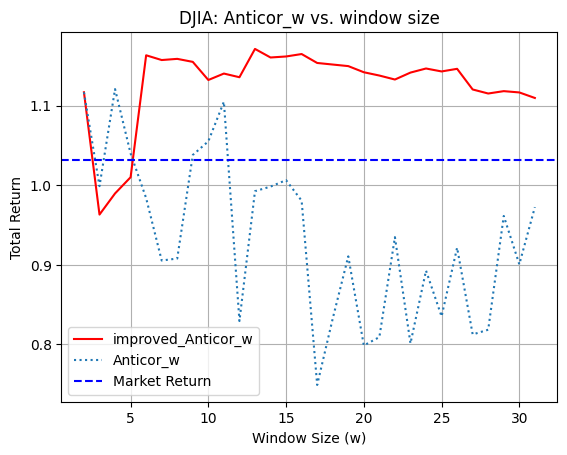

In [ ]:
DJIA_growth_list= [1.1169134760608501, 0.998939227720698, 1.1208992968685312, 1.0400156166388614, 0.9838437114520654, 0.9054765718450873, 0.9080096469200286, 1.0380805082527809, 1.0552987058461507, 1.1049949421141403, 0.829452301625955, 0.992599248860589, 0.9983860184277952, 1.0064561157465028, 0.980675951634768, 0.7491857162803051, 0.8325449041229841, 0.9107327977111306, 0.7987324310850119, 0.8092590504418431, 0.9348607698860933, 0.8013532571970705, 0.8928201739142043, 0.8353050659775412, 0.9216135516261901, 0.8126055302001088, 0.8185381274599435, 0.9614979323679588, 0.9007135206418989, 0.9725614381591241, 1.0242144367544785, 0.9146819158924183, 0.8742310000650113, 0.8893636238584361, 0.9089280363115062, 0.9784942373440643, 1.0250982820725596, 0.9860725451883012, 1.0474209230068154, 1.0489153619267768, 1.0682600571553214, 1.0610698325608425, 1.072284385644983, 1.0667345362498346, 1.0369888129749925, 1.0755767145037967, 1.0490177480127136, 1.0727997480893048, 1.0721813192911118]
DJIA_growth_list_improved= [1.1169134760608501, 0.9632242415202877, 0.9897668577238593, 1.0101367322990669, 1.163359776822243, 1.157385543794072, 1.1588679880914456, 1.1550800702938402, 1.1323170959317634, 1.1404017324482534, 1.1357842520074553, 1.1713568458804895, 1.1605905704240052, 1.1618707902540475, 1.1649208560931703, 1.153708124582313, 1.151735098920872, 1.149762693907464, 1.1420497263178873, 1.1379037011811293, 1.1329034087251788, 1.141631597814001, 1.1467590110463877, 1.1430575564735181, 1.1463538084044198, 1.1204017146437055, 1.1153306769777693, 1.118307796586574, 1.1166851247758345, 1.1097326908009046, 1.0940973032290313, 1.1160346663328977, 1.116915421063245, 1.1120210903001984, 1.1118499543974136, 1.1019921024226482, 1.0882640468720974, 1.0707099525066153, 1.0614136981396813, 1.0673756418525253, 1.0553126574412526, 1.077290369966218, 1.0770286414490078, 1.0875656529365956, 1.0874161626270376, 1.0727545788856228, 1.0753111243216174, 1.0717598491792937, 1.0762757705786252]
window_sizes = list(range(2, 51))

plt.plot(window_sizes[:30], DJIA_growth_list_improved[:30], label='improved_Anticor_w', color='r')
plt.plot(window_sizes[:30], DJIA_growth_list[:30], label='Anticor_w', linestyle=':')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Window Size (w)')
plt.ylabel('Total Return')
plt.title('DJIA: Anticor_w vs. window size')
plt.legend()
plt.grid(True)
plt.show()

Then we adaptively learn and invest in some weighted average of all Anticor$_w$ algorithms with $w$ less than some maximum $W$. Here we use the uniform buy-and-hold investment on the algorithms Anticor$_w$, $w ∈ [2, W]$, denoted by $BAH_W (ANTICOR)$.

[1.1169134760608501, 1.057926351890774, 1.0789173335500264, 1.069191904322235, 1.0521222657482012, 1.0276813167643488, 1.010585363929446, 1.0140222569698627, 1.018608529067228, 1.0272471703719193, 1.009265818667741, 1.007876937850478, 1.0071468671256565, 1.0070975277414311, 1.0053360893343204, 0.9893266910184443, 0.9801042329657702, 0.9762502643405123, 0.9669072204849598, 0.9590248119828041, 0.957874143311532, 0.9507595575790566, 0.9482404539414543, 0.9435348127762911, 0.9426579623302871, 0.9376559457098956, 0.933244174663601, 0.9342532374387567, 0.9330966954802445, 0.9344121869028734, 0.9373090336722805, 0.9366019362416597, 0.9347119078726703, 0.9333781348134281, 0.9326795605705159, 0.9339521904808923, 0.9364155983617484, 0.9377223601203417, 0.9405351437840975, 0.9432446492376646, 0.9462938055283392, 0.9490265680767319, 0.9518930289504122, 0.9545030632072173, 0.9563360798687234, 0.9589282675781815, 0.9608450650342355, 0.9631774542645493, 0.9654020229385608]
[1.1169134760608501, 1.0400

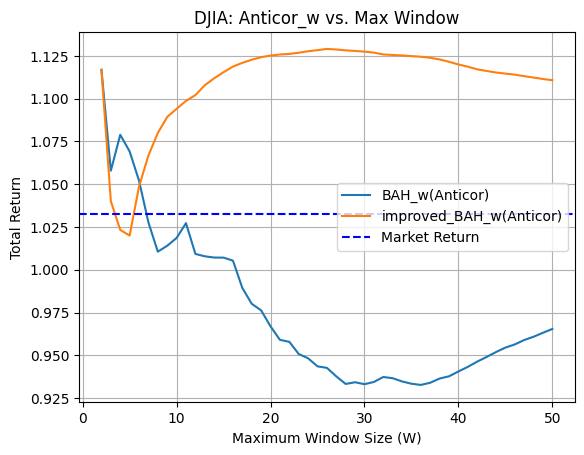

In [ ]:
BAH_Anticor_growth_list = [] # create a list to store BAHw(ANTICOR)
BAH_Anticor_growth_list_improved = [] # create a list to store improved BAHw(ANTICOR)

for i in range(len(DJIA_growth_list)):
  b = np.full(i+1, 1/(i+1)) # initiate portfolio with equal weight
  BAH_Anticor = np.dot(b,DJIA_growth_list[:i+1])
  BAH_Anticor_improved = np.dot(b,DJIA_growth_list_improved[:i+1])
  BAH_Anticor_growth_list.append(BAH_Anticor)
  BAH_Anticor_growth_list_improved.append(BAH_Anticor_improved)

print(BAH_Anticor_growth_list)
print(BAH_Anticor_growth_list_improved)

maximum_window_size = list(range(2, 51))

plt.plot(maximum_window_size, BAH_Anticor_growth_list, label='BAH_w(Anticor)')
plt.plot(maximum_window_size, BAH_Anticor_growth_list_improved, label='improved_BAH_w(Anticor)')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Maximum Window Size (W)')
plt.ylabel('Total Return')
plt.title('DJIA: Anticor_w vs. Max Window')
plt.legend()
plt.grid(True)
plt.show()

**2. DJIA dataset**

In [ ]:
total_return = DJIA_relative_price.prod() # here calculate the total return of each stock for the whole period
print(total_return)
print()

b = np.full(len(total_return), 1/len(total_return) ) # initialize a portfolio with all equal weights
return_UBAH = np.dot(b,total_return.to_numpy()) # calculate the return of uniform buy-and-holds strategy which is the market return
print('the market return: ', return_UBAH) # U-BAH

Ticker
AAPL    1.027749
AMGN    1.011494
AMZN    1.214033
AXP     1.260876
BA      0.681800
CAT     1.164684
CRM     1.061862
CSCO    0.926905
CVX     1.071807
DIS     1.112116
DOW     1.043159
GS      1.185706
HD      0.950096
HON     0.953121
IBM     1.054157
INTC    0.634750
JNJ     0.917129
JPM     1.165123
KO      1.039678
MCD     0.844293
MMM     1.089398
MRK     1.118850
MSFT    1.161429
NKE     0.863421
PG      1.100721
TRV     1.102427
UNH     0.902271
V       1.042453
VZ      1.039177
WMT     1.231086
dtype: float64

the market return:  1.0323924316819728


In [ ]:
# original Anticor Algorithm
stock_num = len(DJIA_relative_price.columns) # number of stocks
growth_list = []  # create a list to store total growth for each window size

for w in range(2, 51):  # Iterate over window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_relative_price):
        if t + 1 < 2 * w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_relative_price.iloc[t, i] / np.dot(b, DJIA_relative_price.iloc[t, :]) # normalize the portfolio
            t += 1

        else:
            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])

            LX1 = DJIA_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i!=j and claims[i, j] > 0:
                        transfer_i_to_j = b[i] * claims[i, j] / np.sum(claims[i])
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [0.9725114969024801, 1.0404375802894494, 1.0865404859863748, 1.0381061415822, 1.0445681691571447, 0.760154629140279, 0.9416076820128192, 0.9875927057949478, 1.0170020997382379, 1.1569153668745058, 0.8029073468417034, 0.9778460235532422, 0.9406891208624608, 0.8186545821360934, 0.9975658907527765, 0.9131948140657391, 0.8800523503049158, 0.9086968198328049, 0.776863184079138, 0.8141259688041562, 0.8473992951686411, 0.7873624792233949, 0.8612066924134493, 0.8294662466581856, 1.0312502466301976, 0.8219932060075033, 0.8370258141964665, 1.0429737281136793, 0.8563648721512321, 0.9822635421564921, 1.007771254036656, 0.9832751566153582, 0.8631861016561905, 0.8679326279409165, 0.8972995057135733, 0.94457475085154, 0.9951040561987441, 0.9660652751274021, 1.0086345573943596, 1.0146902297260478, 1.0447990552889286, 1.0231870307751707, 1.0364411507630398, 1.035646471600477, 1.015456850221062, 1.0343828384706628, 1.0063006821592824, 1.0264505430223374, 1.018876020489988]


In [ ]:
# improved Anticor algorithm
stock_num = len(DJIA_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    return prices.rolling(window=window).std() # calculate rolling standard deviation as a measure of market volatility

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

for initial_w in range(2, 51):  # iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_relative_price.iloc[t, i] / np.dot(b, DJIA_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # calculate dynamic window size based on market volatility
            recent_prices = DJIA_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])

            LX1 = DJIA_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [0.9725114969024801, 0.9722741021844998, 0.9993329305535865, 0.9969415463122933, 1.002159029289301, 0.990544106042086, 0.9909183612435051, 0.9854612635791326, 0.9647430617766222, 0.9877832807455414, 0.988246114777001, 1.017508638905367, 1.013799908895504, 1.0104948655085988, 1.0172131359170895, 1.0144646995067073, 1.0169578033426492, 1.0201347366121518, 1.0304735086517671, 1.043980675118971, 1.0458812480365658, 1.0449850937613243, 1.0530430658189378, 1.0564026969668092, 1.0486710981251337, 1.0496178061454273, 1.0425993626912855, 1.0469109384594737, 1.0400776573665376, 1.042231115303035, 1.057407947036338, 1.0763191867286626, 1.0770346011962995, 1.0785406518094756, 1.0761349080525626, 1.0692612470354337, 1.060591469831398, 1.0464889176001468, 1.036813484973759, 1.051613276976971, 1.044444196448915, 1.0614770930017925, 1.0544593046658344, 1.053596530037169, 1.0461448296508906, 1.0362104945034767, 1.0343310165048514, 1.0319556034362947, 1.0242407144737289]


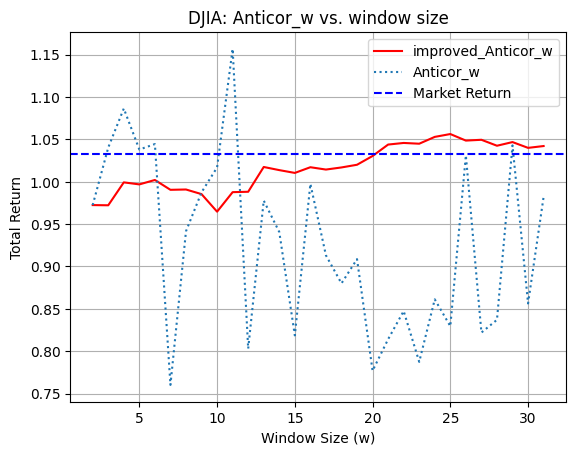

In [ ]:
DJIA_growth_list= [0.9725114969024801, 1.0404375802894494, 1.0865404859863748, 1.0381061415822, 1.0445681691571447, 0.760154629140279, 0.9416076820128192, 0.9875927057949478, 1.0170020997382379, 1.1569153668745058, 0.8029073468417034, 0.9778460235532422, 0.9406891208624608, 0.8186545821360934, 0.9975658907527765, 0.9131948140657391, 0.8800523503049158, 0.9086968198328049, 0.776863184079138, 0.8141259688041562, 0.8473992951686411, 0.7873624792233949, 0.8612066924134493, 0.8294662466581856, 1.0312502466301976, 0.8219932060075033, 0.8370258141964665, 1.0429737281136793, 0.8563648721512321, 0.9822635421564921, 1.007771254036656, 0.9832751566153582, 0.8631861016561905, 0.8679326279409165, 0.8972995057135733, 0.94457475085154, 0.9951040561987441, 0.9660652751274021, 1.0086345573943596, 1.0146902297260478, 1.0447990552889286, 1.0231870307751707, 1.0364411507630398, 1.035646471600477, 1.015456850221062, 1.0343828384706628, 1.0063006821592824, 1.0264505430223374, 1.018876020489988]
DJIA_growth_list_improved= [0.9725114969024801, 0.9722741021844998, 0.9993329305535865, 0.9969415463122933, 1.002159029289301, 0.990544106042086, 0.9909183612435051, 0.9854612635791326, 0.9647430617766222, 0.9877832807455414, 0.988246114777001, 1.017508638905367, 1.013799908895504, 1.0104948655085988, 1.0172131359170895, 1.0144646995067073, 1.0169578033426492, 1.0201347366121518, 1.0304735086517671, 1.043980675118971, 1.0458812480365658, 1.0449850937613243, 1.0530430658189378, 1.0564026969668092, 1.0486710981251337, 1.0496178061454273, 1.0425993626912855, 1.0469109384594737, 1.0400776573665376, 1.042231115303035, 1.057407947036338, 1.0763191867286626, 1.0770346011962995, 1.0785406518094756, 1.0761349080525626, 1.0692612470354337, 1.060591469831398, 1.0464889176001468, 1.036813484973759, 1.051613276976971, 1.044444196448915, 1.0614770930017925, 1.0544593046658344, 1.053596530037169, 1.0461448296508906, 1.0362104945034767, 1.0343310165048514, 1.0319556034362947, 1.0242407144737289]
window_sizes = list(range(2, 51))

plt.plot(window_sizes[:30], DJIA_growth_list_improved[:30], label='improved_Anticor_w', color='r')
plt.plot(window_sizes[:30], DJIA_growth_list[:30], label='Anticor_w', linestyle=':')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Window Size (w)')
plt.ylabel('Total Return')
plt.title('DJIA: Anticor_w vs. window size')
plt.legend()
plt.grid(True)
plt.show()

Then we adaptively learn and invest in some weighted average of all Anticor$_w$ algorithms with $w$ less than some maximum $W$. Here we use the uniform buy-and-hold investment on the algorithms Anticor$_w$, $w ∈ [2, W]$, denoted by $BAH_W (ANTICOR)$.

[0.9725114969024801, 1.0064745385959648, 1.0331631877261014, 1.034398926190126, 1.0364327747835298, 0.9903864171763213, 0.983418026438678, 0.9839398613582119, 0.987613443400437, 1.004543635747844, 0.9862130640291039, 0.9855158106561153, 0.9820676037489112, 0.9703952450622814, 0.9722066214416476, 0.9685183834806534, 0.9633144991761983, 0.9602801836571206, 0.9506266573635427, 0.9438016229355735, 0.9392110358990526, 0.9323088287774322, 0.9292174315442153, 0.9250611321739641, 0.9293086967522134, 0.9251811778774169, 0.921916164407752, 0.9262396488258209, 0.9238301737680764, 0.9257779527143571, 0.928422897918302, 0.9301370310025852, 0.9281082149617853, 0.9263383447552892, 0.9255086636398115, 0.9260382771734708, 0.9279049198498296, 0.9289091397255551, 0.9309533812042423, 0.9330468024172877, 0.9357724671214738, 0.9378537662560857, 0.9401464961283404, 0.9423169501163435, 0.9439422812297819, 0.9459083803002354, 0.9471933228929812, 0.9488445149790095, 0.9502737293771927]
[0.9725114969024801, 0.97

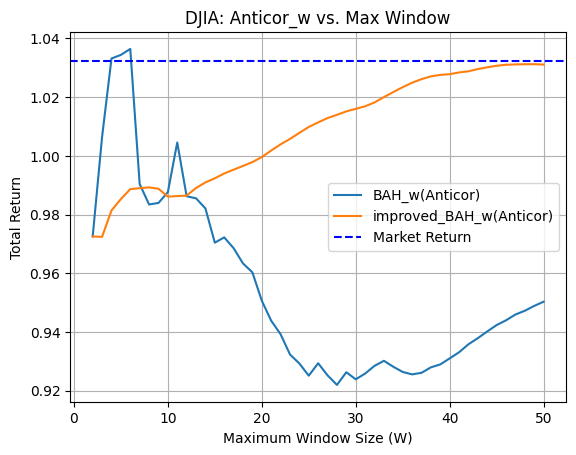

In [ ]:
BAH_Anticor_growth_list = [] # create a list to store BAHw(ANTICOR)
BAH_Anticor_growth_list_improved = [] # create a list to store improved BAHw(ANTICOR)

for i in range(len(DJIA_growth_list)):
  b = np.full(i+1, 1/(i+1)) # initiate portfolio with equal weight
  BAH_Anticor = np.dot(b,DJIA_growth_list[:i+1])
  BAH_Anticor_improved = np.dot(b,DJIA_growth_list_improved[:i+1])
  BAH_Anticor_growth_list.append(BAH_Anticor)
  BAH_Anticor_growth_list_improved.append(BAH_Anticor_improved)

print(BAH_Anticor_growth_list)
print(BAH_Anticor_growth_list_improved)

maximum_window_size = list(range(2, 51))

plt.plot(maximum_window_size, BAH_Anticor_growth_list, label='BAH_w(Anticor)')
plt.plot(maximum_window_size, BAH_Anticor_growth_list_improved, label='improved_BAH_w(Anticor)')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Maximum Window Size (W)')
plt.ylabel('Total Return')
plt.title('DJIA: Anticor_w vs. Max Window')
plt.legend()
plt.grid(True)
plt.show()

**3. S&P500**

In [ ]:
total_return = SP500_relative_price.prod() # here calculate the total return of each stock for the whole period
print(total_return)
print()

b = np.full(len(total_return), 1/len(total_return) ) # initialize a portfolio with all equal weights
return_UBAH = np.dot(b,total_return.to_numpy()) # calculate the return of uniform buy-and-holds strategy which is the market return
print('the market return: ', return_UBAH) # U-BAH

Ticker
AAPL     1.027749
ABBV     0.986912
AMZN     1.214033
AVGO     1.286731
BRK-B    1.114854
COST     1.243375
CRM      1.061862
CVX      1.071807
GOOG     1.271138
GOOGL    1.273069
HD       0.950096
JNJ      0.917129
JPM      1.165123
LLY      1.375107
MA       1.051888
META     1.371288
MRK      1.118850
MSFT     1.161429
NFLX     1.397268
NVDA     2.383956
PG       1.100721
TSLA     0.709242
UNH      0.902271
V        1.042453
XOM      1.129519
dtype: float64

the market return:  1.1731148810711522


In [ ]:
# original Anticor algorithm
stock_num = len(SP500_relative_price.columns) # number of stocks
growth_list = []  # create a list to store total growth for each window size

for w in range(2, 51):  # Iterate over window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(SP500_relative_price):
        if t + 1 < 2 * w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, SP500_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * SP500_relative_price.iloc[t, i] / np.dot(b, SP500_relative_price.iloc[t, :]) # normalize the portfolio
            t += 1

        else:
            growth *= np.dot(b, SP500_relative_price.iloc[t, :])

            LX1 = SP500_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = SP500_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i!=j and claims[i, j] > 0:
                        transfer_i_to_j = b[i] * claims[i, j] / np.sum(claims[i])
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)


Growth for each window size: [1.1810630645562001, 1.0747474951440759, 1.3137131916487057, 1.3615223993636953, 1.1094290179875042, 1.4067602005969533, 1.6684140017915186, 1.3403250033734997, 1.3279786207894841, 1.3169276019271114, 1.2548018324475578, 1.199085427671645, 1.245880437804399, 1.475990711686254, 1.28785759811778, 1.4725505515217268, 1.3397042708908435, 1.3723132689121444, 1.2705916553950616, 1.4577609280637847, 1.2235171272648473, 1.4190406514535348, 1.2816111277110513, 1.3974532318027133, 1.4030646650737204, 1.1898055146092068, 1.188848351935087, 1.1586206058059902, 1.1733117178545827, 1.155499415651363, 1.1357634838722634, 1.2738986732065052, 1.2223168430301434, 1.1431273235132846, 1.3065951686936856, 1.1203312878564637, 1.1352924448737551, 1.2236519766700449, 1.1442569892975851, 1.1354271190425917, 1.17093320600248, 1.1130249689505765, 1.1001569200456145, 1.0970447368789527, 1.124283028446906, 1.106741487102295, 1.1415322388707876, 1.1469767734445069, 1.1521584543607168]


In [ ]:
# improved Anticor algorithm
stock_num = len(SP500_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(SP500_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, SP500_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * SP500_relative_price.iloc[t, i] / np.dot(b, SP500_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices =SP500_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, SP500_relative_price.iloc[t, :])

            LX1 = SP500_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = SP500_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.1196436018472933, 1.0096542960275694, 1.0239115469961042, 1.0233546572023458, 1.178593950055411, 1.1696105078304981, 1.1919811351277398, 1.1782379876676772, 1.1922949614607363, 1.1945015505183487, 1.190682123114638, 1.185490336248469, 1.1887342802174414, 1.226429656801375, 1.2385508106194958, 1.2165670780293854, 1.1964508339609625, 1.2149349585617821, 1.2367095448727023, 1.2678597854419043, 1.275079255810513, 1.2570737809747814, 1.2501319624312142, 1.242902726530699, 1.2090656688365846, 1.1980956718619442, 1.2041472493332297, 1.2112136187417029, 1.2195554700463416, 1.2250127660523291, 1.216264769982916, 1.1806096360648974, 1.1713317952840805, 1.178518868222825, 1.1702893029187236, 1.1774593297255023, 1.1891886024163367, 1.1892341809096876, 1.1783087133482122, 1.1610043078785546, 1.1502921332563547, 1.1620471249920485, 1.1666991810412886, 1.1716628812286758, 1.1635643136364182, 1.1559810831288364, 1.1464850602767804, 1.1421497314364266, 1.1485639486534418

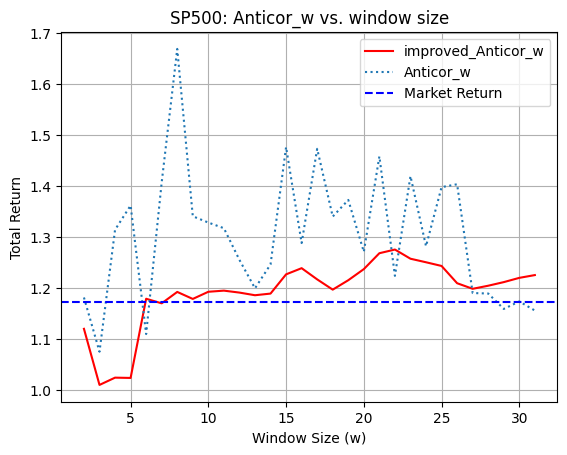

In [ ]:
SP500_growth_list= [1.1810630645562001, 1.0747474951440759, 1.3137131916487057, 1.3615223993636953, 1.1094290179875042, 1.4067602005969533, 1.6684140017915186, 1.3403250033734997, 1.3279786207894841, 1.3169276019271114, 1.2548018324475578, 1.199085427671645, 1.245880437804399, 1.475990711686254, 1.28785759811778, 1.4725505515217268, 1.3397042708908435, 1.3723132689121444, 1.2705916553950616, 1.4577609280637847, 1.2235171272648473, 1.4190406514535348, 1.2816111277110513, 1.3974532318027133, 1.4030646650737204, 1.1898055146092068, 1.188848351935087, 1.1586206058059902, 1.1733117178545827, 1.155499415651363, 1.1357634838722634, 1.2738986732065052, 1.2223168430301434, 1.1431273235132846, 1.3065951686936856, 1.1203312878564637, 1.1352924448737551, 1.2236519766700449, 1.1442569892975851, 1.1354271190425917, 1.17093320600248, 1.1130249689505765, 1.1001569200456145, 1.0970447368789527, 1.124283028446906, 1.106741487102295, 1.1415322388707876, 1.1469767734445069, 1.1521584543607168]
SP500_growth_list_improved= [1.1196436018472933, 1.0096542960275694, 1.0239115469961042, 1.0233546572023458, 1.178593950055411, 1.1696105078304981, 1.1919811351277398, 1.1782379876676772, 1.1922949614607363, 1.1945015505183487, 1.190682123114638, 1.185490336248469, 1.1887342802174414, 1.226429656801375, 1.2385508106194958, 1.2165670780293854, 1.1964508339609625, 1.2149349585617821, 1.2367095448727023, 1.2678597854419043, 1.275079255810513, 1.2570737809747814, 1.2501319624312142, 1.242902726530699, 1.2090656688365846, 1.1980956718619442, 1.2041472493332297, 1.2112136187417029, 1.2195554700463416, 1.2250127660523291, 1.216264769982916, 1.1806096360648974, 1.1713317952840805, 1.178518868222825, 1.1702893029187236, 1.1774593297255023, 1.1891886024163367, 1.1892341809096876, 1.1783087133482122, 1.1610043078785546, 1.1502921332563547, 1.1620471249920485, 1.1666991810412886, 1.1716628812286758, 1.1635643136364182, 1.1559810831288364, 1.1464850602767804, 1.1421497314364266, 1.1485639486534418]
window_sizes = list(range(2, 51))

plt.plot(window_sizes[:30], SP500_growth_list_improved[:30], label='improved_Anticor_w', color='r')
plt.plot(window_sizes[:30], SP500_growth_list[:30], label='Anticor_w', linestyle=':')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Window Size (w)')
plt.ylabel('Total Return')
plt.title('SP500: Anticor_w vs. window size')
plt.legend()
plt.grid(True)
plt.show()

[1.1810630645562001, 1.1279052798501379, 1.1898412504496605, 1.232761537678169, 1.2080950337400362, 1.2412058948828557, 1.302235624441236, 1.306996796807769, 1.309328110583515, 1.310088059717875, 1.305062039056937, 1.296230654774829, 1.2923575611617195, 1.3054742147706144, 1.3042997736604254, 1.314815447276757, 1.3162794957246442, 1.3193924831239499, 1.31682401850664, 1.3238708639844972, 1.3190921146168948, 1.3236352299276517, 1.3218080950486688, 1.3249599757467538, 1.3280841633198326, 1.3227657537540394, 1.3178058499829668, 1.312120662690932, 1.3073341473517472, 1.302272989628401, 1.2969017152491713, 1.296182870185338, 1.2939445057260897, 1.2895087062492423, 1.2899968908905122, 1.2852839574728996, 1.281230132808058, 1.2797149181728469, 1.2762416379452761, 1.2727212749727093, 1.2702386391441673, 1.2664954565205098, 1.2626271184629543, 1.2588638825178637, 1.2558731968718422, 1.2526312031812001, 1.2502673954299146, 1.248115507471885, 1.2461572002655343]
[1.1196436018472933, 1.06464894893

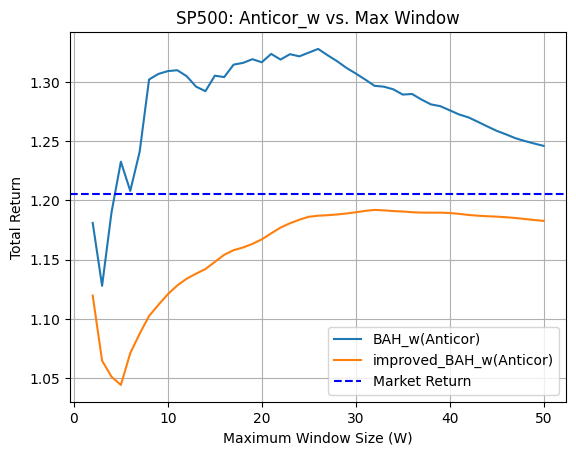

In [ ]:
BAH_Anticor_growth_list = [] # create a list to store BAHw(ANTICOR)
BAH_Anticor_growth_list_improved = [] # create a list to store improved BAHw(ANTICOR)

for i in range(len(SP500_growth_list)):
  b = np.full(i+1, 1/(i+1)) # initiate portfolio with equal weight
  BAH_Anticor = np.dot(b,SP500_growth_list[:i+1])
  BAH_Anticor_improved = np.dot(b,SP500_growth_list_improved[:i+1])
  BAH_Anticor_growth_list.append(BAH_Anticor)
  BAH_Anticor_growth_list_improved.append(BAH_Anticor_improved)

print(BAH_Anticor_growth_list)
print(BAH_Anticor_growth_list_improved)

maximum_window_size = list(range(2, 51))

plt.plot(maximum_window_size, BAH_Anticor_growth_list, label='BAH_w(Anticor)')
plt.plot(maximum_window_size, BAH_Anticor_growth_list_improved, label='improved_BAH_w(Anticor)')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Maximum Window Size (W)')
plt.ylabel('Total Return')
plt.title('SP500: Anticor_w vs. Max Window')
plt.legend()
plt.grid(True)
plt.show()

**4. Nasdaq**

In [ ]:
total_return = Nasdaq_relative_price.prod() # here calculate the total return of each stock for the whole period
print(total_return)
print()

b = np.full(len(total_return), 1/len(total_return) ) # initialize a portfolio with all equal weights
return_UBAH = np.dot(b,total_return.to_numpy()) # calculate the return of uniform buy-and-holds strategy which is the market return
print('the market return: ', return_UBAH) # U-BAH

Ticker
AAPL     1.027749
ADBE     0.823349
AMAT     1.423990
AMD      1.191658
AMGN     1.011494
AMZN     1.214033
AVGO     1.286731
CMCSA    0.875206
COST     1.243375
CSCO     0.926905
GOOG     1.271138
GOOGL    1.273069
INTU     0.993802
ISRG     1.203698
LIN      1.043606
META     1.371288
MSFT     1.161429
MU       1.599551
NFLX     1.397268
NVDA     2.383956
PEP      0.997375
QCOM     1.492675
TMUS     1.047204
TSLA     0.709242
TXN      1.168994
dtype: float64

the market return:  1.2055514539258045


In [ ]:
# original Anticor algorithm
stock_num = len(Nasdaq_relative_price.columns) # number of stocks
growth_list = []  # create a list to store total growth for each window size

for w in range(2, 31):  # Iterate over window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(Nasdaq_relative_price):
        if t + 1 < 2 * w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * Nasdaq_relative_price.iloc[t, i] / np.dot(b, Nasdaq_relative_price.iloc[t, :]) # normalize the portfolio
            t += 1

        else:
            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])

            LX1 = Nasdaq_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = Nasdaq_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i!=j and claims[i, j] > 0:
                        transfer_i_to_j = b[i] * claims[i, j] / np.sum(claims[i])
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.2911631629023017, 0.9964045325577015, 1.206259998479077, 1.1614776449962951, 1.180758081042753, 1.1460644070977437, 1.220434385768777, 1.4452195447003615, 1.2293922013232697, 1.187832461774675, 1.16910152950145, 0.9986534204287318, 1.124827005967691, 1.168814801770208, 1.0544363780193393, 1.2864191460573653, 1.2454430033515018, 1.3045113007286087, 0.9616099382985203, 1.2933969098772284, 1.4655599614808528, 1.3025937119869926, 1.1258446433759186, 1.1770495276376918, 1.206209388208765, 1.1669271012521372, 1.3466363236028123, 1.1070319143396699, 1.1999829360860041]


In [ ]:
# improved Anticor algorithm
stock_num = len(Nasdaq_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

for initial_w in range(2, 31):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(Nasdaq_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * Nasdaq_relative_price.iloc[t, i] / np.dot(b, Nasdaq_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices =Nasdaq_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])

            LX1 = Nasdaq_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = Nasdaq_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.120915800178965, 1.066054145826719, 1.0874615898124564, 1.0924950005332916, 1.0950344942392052, 1.0851747026909808, 1.0854476363701722, 1.0646998842341677, 1.054929173353485, 1.0701202912238912, 1.0683342025289755, 1.0712609918943012, 1.1090253168544253, 1.0937791273722774, 1.0588604030236866, 1.112175713297818, 1.0984286182418581, 1.0974013525743322, 1.1151554576174014, 1.1394456830832873, 1.1432930646180959, 1.1281843778207072, 1.1383881825253752, 1.1707219623857525, 1.1364716285516259, 1.1390978321704621, 1.1722384433534785, 1.178957874374874, 1.1875233142151402]


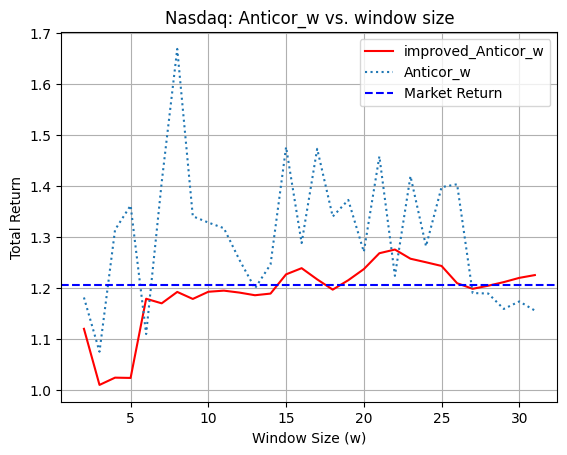

In [ ]:
Nasdaq_growth_list= [1.2911631629023017, 0.9964045325577015, 1.206259998479077, 1.1614776449962951, 1.180758081042753, 1.1460644070977437, 1.220434385768777, 1.4452195447003615, 1.2293922013232697, 1.187832461774675, 1.16910152950145, 0.9986534204287318, 1.124827005967691, 1.168814801770208, 1.0544363780193393, 1.2864191460573653, 1.2454430033515018, 1.3045113007286087, 0.9616099382985203, 1.2933969098772284, 1.4655599614808528, 1.3025937119869926, 1.1258446433759186, 1.1770495276376918, 1.206209388208765, 1.1669271012521372, 1.3466363236028123, 1.1070319143396699, 1.1999829360860041]
Nasdaq_growth_list_improved= [1.120915800178965, 1.066054145826719, 1.0874615898124564, 1.0924950005332916, 1.0950344942392052, 1.0851747026909808, 1.0854476363701722, 1.0646998842341677, 1.054929173353485, 1.0701202912238912, 1.0683342025289755, 1.0712609918943012, 1.1090253168544253, 1.0937791273722774, 1.0588604030236866, 1.112175713297818, 1.0984286182418581, 1.0974013525743322, 1.1151554576174014, 1.1394456830832873, 1.1432930646180959, 1.1281843778207072, 1.1383881825253752, 1.1707219623857525, 1.1364716285516259, 1.1390978321704621, 1.1722384433534785, 1.178957874374874, 1.1875233142151402]
window_sizes = list(range(2, 51))

plt.plot(window_sizes[:30], SP500_growth_list_improved[:30], label='improved_Anticor_w', color='r')
plt.plot(window_sizes[:30], SP500_growth_list[:30], label='Anticor_w', linestyle=':')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Window Size (w)')
plt.ylabel('Total Return')
plt.title('Nasdaq: Anticor_w vs. window size')
plt.legend()
plt.grid(True)
plt.show()

[1.2911631629023017, 1.1437838477300015, 1.1646092313130265, 1.1638263347338438, 1.1672126839956256, 1.1636879711793118, 1.1717946018349499, 1.2059727196931262, 1.2085748843186979, 1.2065006420642956, 1.2031007227404003, 1.1860634475477612, 1.1813529520416022, 1.1804573698793597, 1.172055970422025, 1.1792036688992336, 1.1831001003376025, 1.1898451670259917, 1.1778327865666511, 1.18361099273218, 1.1970371341011643, 1.2018351603687023, 1.1985312248472766, 1.1976361541302105, 1.1979790834933528, 1.1967847764840756, 1.2023348337847688, 1.1989311580903015, 1.1989674262970496]
[1.120915800178965, 1.093484973002842, 1.0914771786060466, 1.091731634087858, 1.0923922061181275, 1.0911892888802694, 1.0903690528073986, 1.0871604067357445, 1.0835791585821601, 1.0822332718463334, 1.08096972009021, 1.0801606594072177, 1.0823810176723874, 1.0831951683652368, 1.0815728506758, 1.0834855295896761, 1.0843645348045106, 1.0850888024583893, 1.0866712579930742, 1.0893099792475849, 1.0918806023604664, 1.0935307

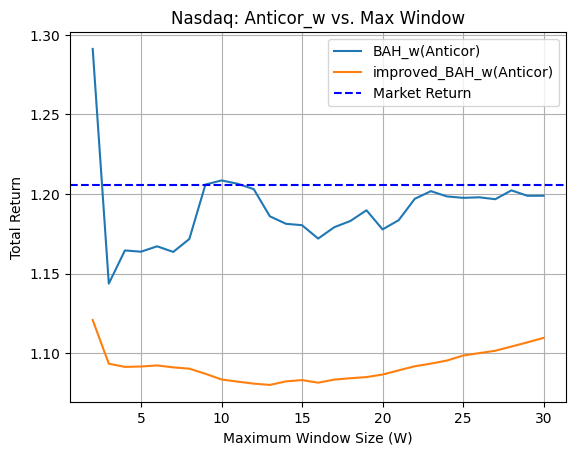

In [ ]:
BAH_Anticor_growth_list = [] # create a list to store BAHw(ANTICOR)
BAH_Anticor_growth_list_improved = [] # create a list to store improved BAHw(ANTICOR)

for i in range(len(Nasdaq_growth_list)):
  b = np.full(i+1, 1/(i+1)) # initiate portfolio with equal weight
  BAH_Anticor = np.dot(b,Nasdaq_growth_list[:i+1])
  BAH_Anticor_improved = np.dot(b,Nasdaq_growth_list_improved[:i+1])
  BAH_Anticor_growth_list.append(BAH_Anticor)
  BAH_Anticor_growth_list_improved.append(BAH_Anticor_improved)

print(BAH_Anticor_growth_list)
print(BAH_Anticor_growth_list_improved)

maximum_window_size = list(range(2, 31))

plt.plot(maximum_window_size, BAH_Anticor_growth_list, label='BAH_w(Anticor)')
plt.plot(maximum_window_size, BAH_Anticor_growth_list_improved, label='improved_BAH_w(Anticor)')
plt.axhline(y=return_UBAH, color='b', linestyle='--', label='Market Return')

plt.xlabel('Maximum Window Size (W)')
plt.ylabel('Total Return')
plt.title('Nasdaq: Anticor_w vs. Max Window')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**

For the four datasets, according to the graphs, the improved anticor algorithm does not outperform the original Anticor algorithm or the market return. Although for the first dataset it beats the original algorithm and the market return for most windows, it underperforms the algorithm and the market for most cases. However, we can see while the original Anticor algorthm can loss money, the improved algorithm has positive returns for almost all cases, which means it manages the volatility effectively compared to the original algorithm.

# **Optimization of Parameters**

The window size $\omega$ is a really important input parameter for the Anticor algorithm since the performance of the algorithm (both original and improved) depends significantly on the window size. However, for different data set, the algorithm performs differently with respect to the different window size, so there is no way to find a specific window size to maximize the returns for all data set. But we can adaptively learn and invest in some weighted average of all Anticor$_w$ algorithms with $w$ less than some maximum $W$. For example, for my analysis I use the uniform buy-and-hold investment on the algorithms Anticor$_w$ (both original and improved), $w ∈ [2, W]$. The results will be smooth out and more stable.

# **Walk Forward Analysis**

Consider the Walk Forward Analysis, we can focus on a specific dataset and optimizing the window size $\omega$ on a moving time window of historical data. The objective function will be: maximize $\prod_{t=1}^{n} \mathbf{b}_t \cdot \mathbf{x}_t$ with respect to $\mathbf{b}_t$. However, since the market changes all the time, the optimized window size may not be suffcient to capture the market as time goes. So it would be better if we consider adaptively learning and investing in some weighted average of all Anticor$_w$ algorithms

# **Extension**

For extension, I also add a momentum indicator which is RSI to avoid transferring funds based purely on mean reversion when momentum indicators suggest a strong trend continuation. But the results are only slightly different compared to the improved algorithm.

**1. DJIA dataset (old)**

In [ ]:
# add momentum indicator
import numpy as np
import pandas as pd

stock_num = len(DJIA_old_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_old_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_old_relative_price.iloc[t, i] / np.dot(b, DJIA_old_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices = DJIA_old_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, DJIA_old_relative_price.iloc[t, :])

            LX1 = DJIA_old_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_old_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            # Calculate RSI for momentum adjustment
            rsi = calculate_rsi(DJIA_relative_price.iloc[:t + 1, :], window=14).iloc[-1]
            for i in range(m):
                if rsi[i] > 70:
                    b_new[i] *= 0.9  # Decrease weight for overbought stocks
                elif rsi[i] < 30:
                    b_new[i] *= 1.1  # Increase weight for oversold stocks

            # Normalize the updated portfolio weights again
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)


Growth for each window size: [1.1160136880707168, 0.9624606726058815, 0.9889725056465165, 1.0096022255793888, 1.1623767296872622, 1.1565142648286697, 1.15871658642236, 1.1549291212913757, 1.1321691267402225, 1.1402527529084265, 1.1356358501308357, 1.1712038058123864, 1.1604389324570357, 1.1617189763058695, 1.1647686708549934, 1.1535573961566368, 1.151584623867487, 1.14961248230045, 1.1419005202474117, 1.137755037095455, 1.132755394452707, 1.141482447063657, 1.1466091900572826, 1.1429082193526683, 1.1462040406480911, 1.1202553372183979, 1.1151849623309271, 1.1181616934810226, 1.116539236152158, 1.1095877072200133, 1.0939543601779356, 1.115889088858658, 1.1167698275498434, 1.1118765892296512, 1.1117027458249205, 1.1018390301554732, 1.0880982836454651, 1.0705767537954345, 1.0614651401325819, 1.0674151286011375, 1.0553615388113062, 1.0772990345217341, 1.0770397529509659, 1.0875772196665534, 1.0874272444148496, 1.0727549381730794, 1.0753114538688375, 1.0717601700800086, 1.0762766939314126]


**2. DJIA dataset**

In [ ]:
# add momentum indicator
import numpy as np
import pandas as pd

stock_num = len(DJIA_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(DJIA_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * DJIA_relative_price.iloc[t, i] / np.dot(b, DJIA_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices = DJIA_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, DJIA_relative_price.iloc[t, :])

            LX1 = DJIA_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = DJIA_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            # Calculate RSI for momentum adjustment
            rsi = calculate_rsi(DJIA_relative_price.iloc[:t + 1, :], window=14).iloc[-1]
            for i in range(m):
                if rsi[i] > 70:
                    b_new[i] *= 0.9  # Decrease weight for overbought stocks
                elif rsi[i] < 30:
                    b_new[i] *= 1.1  # Increase weight for oversold stocks

            # Normalize the updated portfolio weights again
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [0.9712917714379108, 0.9710543329295568, 0.9980740551569545, 0.9956852662330337, 1.0008678377592488, 0.9892738681800683, 0.9897160183925386, 0.9842655421622173, 0.963572478950303, 0.986584741656863, 0.9870470258499103, 1.016274112643391, 1.0125699979183675, 1.0092687593554257, 1.0159735140767376, 1.0132126443532163, 1.0157339276575164, 1.0189976069647408, 1.0302112646959791, 1.0437093880371298, 1.045609467075012, 1.0447135456729337, 1.0527694237994112, 1.056128181919268, 1.0483985921980559, 1.0493450542059573, 1.0423284345477033, 1.0466388899752088, 1.0398073843645304, 1.041960282164431, 1.0571331779125501, 1.07603958375396, 1.0767548953383093, 1.0782615135723879, 1.075855199089608, 1.0689728029997099, 1.0603153141133737, 1.0462117613687043, 1.0368353177436316, 1.0517112360418215, 1.0444973863319023, 1.0615001102932782, 1.0544752239699593, 1.0536129752558567, 1.046161289619816, 1.0362253359661941, 1.0343424099176917, 1.0319694620803495, 1.024241857599138]


**3. S&P500**

In [ ]:
# add momentum indicator
import numpy as np
import pandas as pd

# Assume DJIA_relative_price and DJIA_relative_price_log are already defined DataFrames
# DJIA_relative_price: DataFrame of relative prices
# DJIA_relative_price_log: DataFrame of log prices

stock_num = len(SP500_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(SP500_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, SP500_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * SP500_relative_price.iloc[t, i] / np.dot(b, SP500_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices = SP500_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, SP500_relative_price.iloc[t, :])

            LX1 = SP500_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = SP500_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            # Calculate RSI for momentum adjustment
            rsi = calculate_rsi(SP500_relative_price.iloc[:t + 1, :], window=14).iloc[-1]
            for i in range(m):
                if rsi[i] > 70:
                    b_new[i] *= 0.9  # Decrease weight for overbought stocks
                elif rsi[i] < 30:
                    b_new[i] *= 1.1  # Increase weight for oversold stocks

            # Normalize the updated portfolio weights again
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)

Growth for each window size: [1.1157201178361023, 1.009654253999471, 1.0239115290709246, 1.0233546635258508, 1.1744638596147836, 1.1655118699786093, 1.187804076980527, 1.174109273784252, 1.1881164713396806, 1.19031661237185, 1.1865105042599509, 1.1813473508716068, 1.1846334565984764, 1.22219434964627, 1.234272174072773, 1.2123220349332522, 1.1922936023498973, 1.2114527017329706, 1.2367961407152657, 1.2679485621588042, 1.2751685381211448, 1.2571618023413123, 1.2502194977772407, 1.2429897555998812, 1.209150328475405, 1.1981795633506869, 1.204231564446013, 1.2112984281662083, 1.2196408640895162, 1.2250985469100368, 1.216349934311327, 1.1806922841559782, 1.1714137951932588, 1.1786013396018369, 1.1703713060559109, 1.1775402297370585, 1.1892693091108975, 1.1893184733019855, 1.1783905611068772, 1.1610731315183345, 1.150534261613131, 1.1620965787120217, 1.1667490604675794, 1.1717130112514806, 1.1636142838367083, 1.1560320652232436, 1.1465354369715541, 1.142206593749224, 1.1485639507062648]


**4. Nasdaq**

In [ ]:
# add momentum indicator
import numpy as np
import pandas as pd

# Assume DJIA_relative_price and DJIA_relative_price_log are already defined DataFrames
# DJIA_relative_price: DataFrame of relative prices
# DJIA_relative_price_log: DataFrame of log prices

stock_num = len(Nasdaq_relative_price.columns)  # number of stocks
growth_list = []  # create a list to store total growth for each window size
claim_threshold = 0.01  # Minimum threshold for claims to trigger transfers

def calculate_market_volatility(prices, window):
    # Calculate rolling standard deviation as a measure of market volatility
    return prices.rolling(window=window).std()

def adjust_window_size(avg_volatility, min_window=2, max_window=50, vol_threshold=0.02):
    # Adjust the window size based on the market volatility
    if avg_volatility > vol_threshold:
        return max(min_window, int(min_window / avg_volatility))
    else:
        return min(max_window, int(max_window * avg_volatility))

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

for initial_w in range(2, 51):  # Iterate over initial window sizes from 2 to 50
    b = np.full(stock_num, 1 / stock_num)  # start with equal weight for each stock
    t = 0
    m = stock_num
    growth = 1

    while t < len(Nasdaq_relative_price):
        if t + 1 < 2 * initial_w:  # two windows of time are needed to start predicting the next day's portfolio
            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])
            for i in range(len(b)):
                b[i] = b[i] * Nasdaq_relative_price.iloc[t, i] / np.dot(b, Nasdaq_relative_price.iloc[t, :])  # normalize the portfolio
            t += 1

        else:
            # Calculate dynamic window size based on market volatility
            recent_prices = Nasdaq_relative_price.iloc[max(0, t - initial_w):t + 1, :]
            market_volatility = calculate_market_volatility(recent_prices, window=initial_w)
            avg_volatility = market_volatility.mean().mean()  # Get the average volatility value
            w = max(2, adjust_window_size(avg_volatility))  # Ensure w is at least 2

            if t - 2 * w + 1 < 0:
                break  # If there is not enough data for the calculated window size, break the loop

            growth *= np.dot(b, Nasdaq_relative_price.iloc[t, :])

            LX1 = Nasdaq_relative_price_log.iloc[t - 2 * w + 1:t - w + 1, :]
            LX2 = Nasdaq_relative_price_log.iloc[t - w + 1:t + 1, :]

            mu1 = LX1.mean()
            mu2 = LX2.mean()

            sigma1 = LX1.std()
            sigma2 = LX2.std()

            Mcov = np.zeros((m, m))
            Mcor = np.zeros((m, m))

            for i in range(m):
                for j in range(m):
                    Mcov[i, j] = np.dot((LX1.iloc[:, i] - mu1[i]).T, (LX2.iloc[:, j] - mu2[j])) / (w - 1)
                    if sigma1[i] != 0 and sigma2[j] != 0:
                        Mcor[i, j] = Mcov[i, j] / (sigma1[i] * sigma2[j])
                    else:
                        Mcor[i, j] = 0

            claims = np.zeros((m, m))
            for i in range(m):  # here calculate claims
                for j in range(m):
                    if i != j and mu2[i] >= mu2[j] and Mcor[i, j] > 0:
                        claims[i, j] = Mcor[i, j]
                        if Mcor[i, i] < 0:
                            claims[i, j] -= Mcor[i, i]
                        if Mcor[j, j] < 0:
                            claims[i, j] -= Mcor[j, j]

            # Implement threshold for claims
            claims[claims < claim_threshold] = 0

            b_new = np.copy(b)
            for i in range(m):  # weights shift
                for j in range(m):
                    if i != j and claims[i, j] > 0:
                        # Adjust transfer by volatility
                        transfer_i_to_j = (b[i] * claims[i, j]) / np.sum(claims[i])
                        # Risk management: adjust transfer amount based on volatility
                        transfer_i_to_j *= min(1, 1 / (sigma2[i] + sigma2[j]))
                        b_new[i] -= transfer_i_to_j
                        b_new[j] += transfer_i_to_j

            # Normalize the updated portfolio weights
            b_new /= np.sum(b_new)

            # Calculate RSI for momentum adjustment
            rsi = calculate_rsi(Nasdaq_relative_price.iloc[:t + 1, :], window=14).iloc[-1]
            for i in range(m):
                if rsi[i] > 70:
                    b_new[i] *= 0.9  # Decrease weight for overbought stocks
                elif rsi[i] < 30:
                    b_new[i] *= 1.1  # Increase weight for oversold stocks

            # Normalize the updated portfolio weights again
            b_new /= np.sum(b_new)

            b = b_new
            t += 1

    growth_list.append(growth)  # Append growth value of the current window size to the list

print("Growth for each window size:", growth_list)


Growth for each window size: [1.120921829446994, 1.0660541458267183, 1.087461589812456, 1.0924950005332925, 1.0950344942392056, 1.0851747026909804, 1.0854476363701722, 1.0646998842341684, 1.054929173353485, 1.0701202912238912, 1.0683342025289755, 1.0712609918943012, 1.1090774453433987, 1.0937791273722768, 1.0588604030236866, 1.112175713297818, 1.0984286182418581, 1.0974013525743322, 1.1151554576174005, 1.139445683083288, 1.1432930646180957, 1.1281843778207072, 1.1383881825253745, 1.170721962385752, 1.136471628551626, 1.1390978321704628, 1.1722384433534792, 1.1789578743748748, 1.1875233142151407, 1.2394582982702242, 1.1636341264722678, 1.2329696887053478, 1.222022826148249, 1.1433539953384488, 1.1312867551424168, 1.1367295100356076, 1.1476749895984908, 1.1174429197133418, 1.1387215025055357, 1.1226343876578015, 1.104281526110813, 1.1283238909727404, 1.1438147967157233, 1.1993193374876054, 1.2046556733668887, 1.2035669605291388, 1.197812075775435, 1.1820414114692552, 1.1829505682222077]


# **Reference**

**Python Packages**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[1] Allan Borodin, Ran El-Yaniv, and Vincent Gogan. Can we learn to beat
the best stock. In Advances in Neural Information Processing Systems, volume 16. MIT Press, 2003.

[2] Harry M. Markowitz. Portfolio Selection: Efficient Diversification of Investments. Yale University Press, 1959.

[3] Thomas M Cover and David H Gluss. Empirical bayes stock market portfolios. Advances in applied mathematics, 7(2):170-181, 1986.

[4] Joy A. Thomas Thomas M. Cover. Elements of information theory. John
Wiley & Sons, 1999.

[5] Thomas M Cover. Universal portfolios. Mathematical finance, 1(1):1-29,1991

[6] David P Helmbold, Robert E Schapire, Yoram Singer, and Manfred K
Warmuth. On-line portfolio selection using multiplicative updates. Mathematical Finance, 8(4):325–347, 1998.

[7] Zijin Peng, Weijun Xu, and Hongyi Li. A novel online portfolio selection strategy with multiperiodical asymmetric mean reversion. Discrete
Dynamics in Nature and Society, 2020:1–13, 2020.

[8] Sanath Kumar Ramesh. yfinance: Yahoo finance market data downloader.
https://github.com/ranaroussi/yfinance, 2022.

[9] Wes McKinney et al. Data structures for statistical computing in python.
In Proceedings of the 9th Python in Science Conference, volume 445, pages
51–56. Austin, TX, 2010.

[10] Charles R. Harris, K. Jarrod Millman, St´efan J. van der Walt, Ralf
Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, Robert Kern, Matti Picus,
Stephan Hoyer, Marten H. van Kerkwijk, Matthew Brett, Allan Haldane,
Jaime Fern´andez del R´ıo, Mark Wiebe, Pearu Peterson, Pierre G´erardMarchant, Kevin Sheppard, Tyler Reddy, Warren Weckesser, Hameer Abbasi, Christoph Gohlke, and Travis E. Oliphant. Array programming with
NumPy. Nature, 585(7825):357–362, September 2020.

[11] John D Hunter. Matplotlib: A 2d graphics environment. Computing in
science & engineering, 9(3):90–95, 2007.

(See strategy.bib)